### Import neccessary libraries

In [32]:
import numpy as np
import pandas as pa
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import datetime

### Styling

In [ ]:
%matplotlib inline
sns.set(style="darkgrid", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})

### Get historical data from Bolin's Centre for Climate Research in Stockholm

In [34]:
data = pa.read_csv("https://bolin.su.se/data/data/stockholm_daily_mean_temperature.csv", parse_dates=['date'])

### The data
"*Data are provided in a comma-separated values (csv) text file. The data file has five columns with the following headers: date, raw, homo, adjust, site.*

*Column 1: Date (yyyy-mm-dd).*

*Column 2: Non-homogenized daily mean temperature according to the observations.*

*Column 3: Homogenized daily mean temperature, adjusted after 1870 to account for the urban heat island effect and with some early values infilled in using data extrapolated from Uppsala.*

*Column 4: Homogenized daily mean temperature, as in column 3, but with additional adjustment of May⁠ – August temperatures before 1859 to correct for a supposed warm bias in summer months.*

*Column 5: Data source ID code, identifying data from: (1) Stockholm, manual observations, (2) Uppsala, adjusted to represent Stockholm, (3) Stockholm, SMHI automatic weather station (used from 2013 onwards). Data from Uppsala are used for a few short periods in 1756 and 1763 and only in the homogenized data in column 3 and 4.*"

In [35]:
data

,date,raw,homo,adjust,site
0,1756-01-01,-8.7,-8.7,-8.7,1
1,1756-01-02,-9.2,-9.2,-9.2,1
2,1756-01-03,-8.6,-8.6,-8.6,1
3,1756-01-04,-7.7,-7.7,-7.7,1
4,1756-01-05,-7.2,-7.2,-7.2,1
...,...,...,...,...,...
97329,2022-06-24,21.7,20.6,20.6,3
97330,2022-06-25,23.0,21.9,21.9,3
97331,2022-06-26,24.2,23.1,23.1,3
97332,2022-06-27,25.2,24.1,24.1,3


In [36]:
data.describe()

,raw,homo,adjust,site
count,97334.000000,97334.000000,97334.000000,97334.000000
mean,6.167418,5.912423,5.847555,1.073438
std,11.956149,8.345031,8.272928,0.373182
min,-999.000000,-27.700000,-27.700000,1.000000
25%,0.200000,-0.100000,-0.100000,1.000000
50%,5.800000,5.500000,5.400000,1.000000
75%,13.300000,13.000000,12.900000,1.000000
max,28.300000,27.500000,27.500000,3.000000


### Replace missing values with null

In [37]:
data = data.where(data != -999.0, None)

### Average temperature each year, from 1756-2022

<AxesSubplot:>

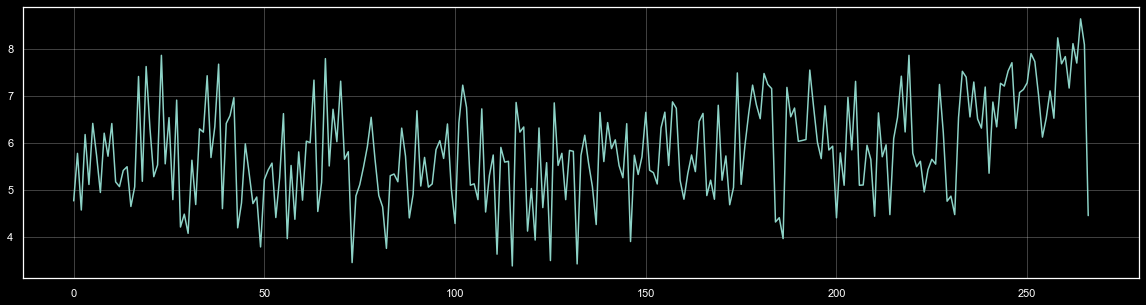

In [50]:
data['adjust'].groupby(np.arange(len(data))//365).mean().plot.line(figsize=(20,5))

### First 20 years shown in average temperature pet month

<AxesSubplot:>

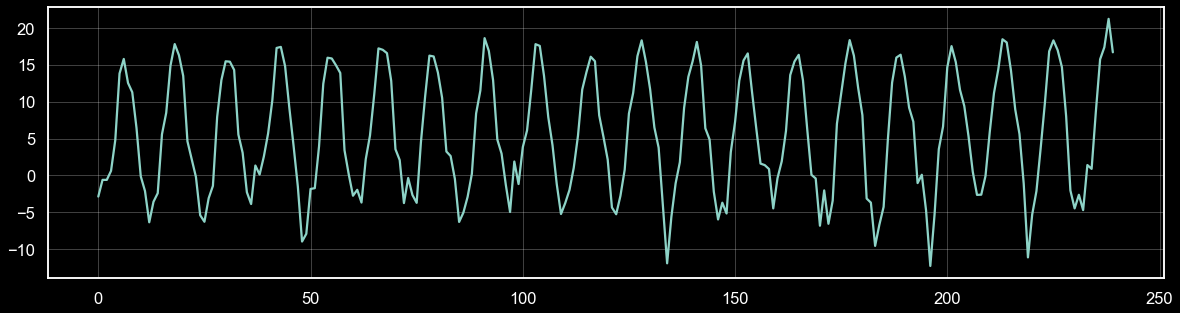

In [40]:
data['adjust'].groupby(np.arange(len(data))//30).mean()[:12*20].plot.line(figsize=(20, 5))

In [41]:
df_stationarityTest = adfuller(data['adjust'], autolag='AIC')

In [42]:
df_stationarityTest[1]

0.0

### Function for checking the amount of correlation between the day being predicted and the previous days, which in this case looks to be that the first few days have the most impact

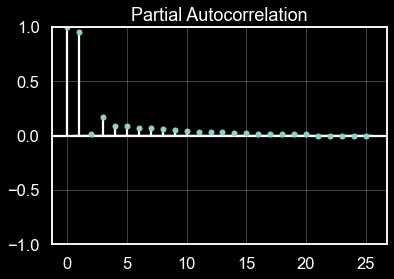

In [43]:
pacf = plot_pacf(data['adjust'], lags=25, method='ywm')

In [44]:
split_date = round((datetime.datetime.now().year-1756)*0.8*365) # 1756 = year first recorded

In [14]:
train_data = data['adjust'][:split_date]

In [15]:
test_data = data['adjust'][split_date:]

In [16]:
ar_model = AutoReg(train_data, lags=[1, 2, 4], seasonal=True, period=365).fit()

In [17]:
pred = ar_model.predict(start=len(train_data), end=(len(data)), dynamic=False)

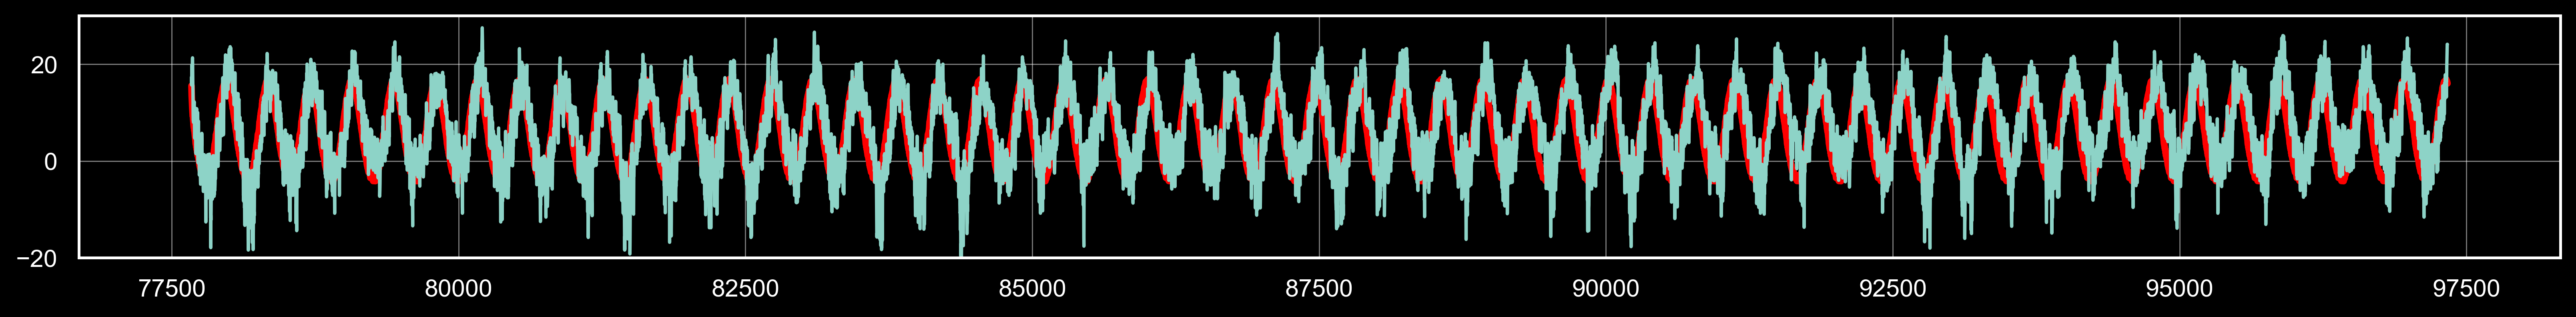

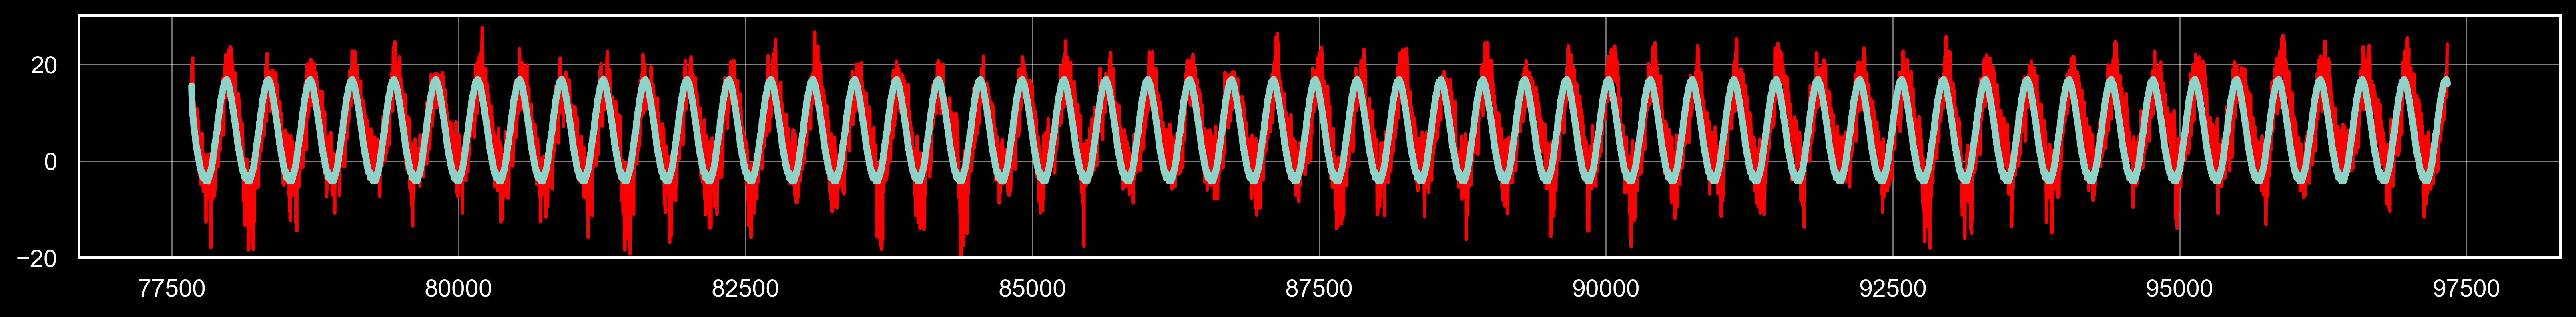

In [88]:
plt.figure(figsize=(20, 2), dpi=400)
plt.axis([None, None, -20, 30])
plt.plot(pred, color='red', linewidth=3)
plt.plot(test_data)

plt.figure(figsize=(20, 2), dpi=400)
plt.axis([None, None, -20, 30])
plt.plot(test_data, color='red')
plt.plot(pred, linewidth=3)

In [19]:
pred

77672    15.525522
77673    14.478995
77674    13.482310
77675    12.921229
77676    12.288908
           ...    
97330    16.470423
97331    16.334742
97332    16.242723
97333    16.171831
97334    16.006103
Length: 19663, dtype: float64

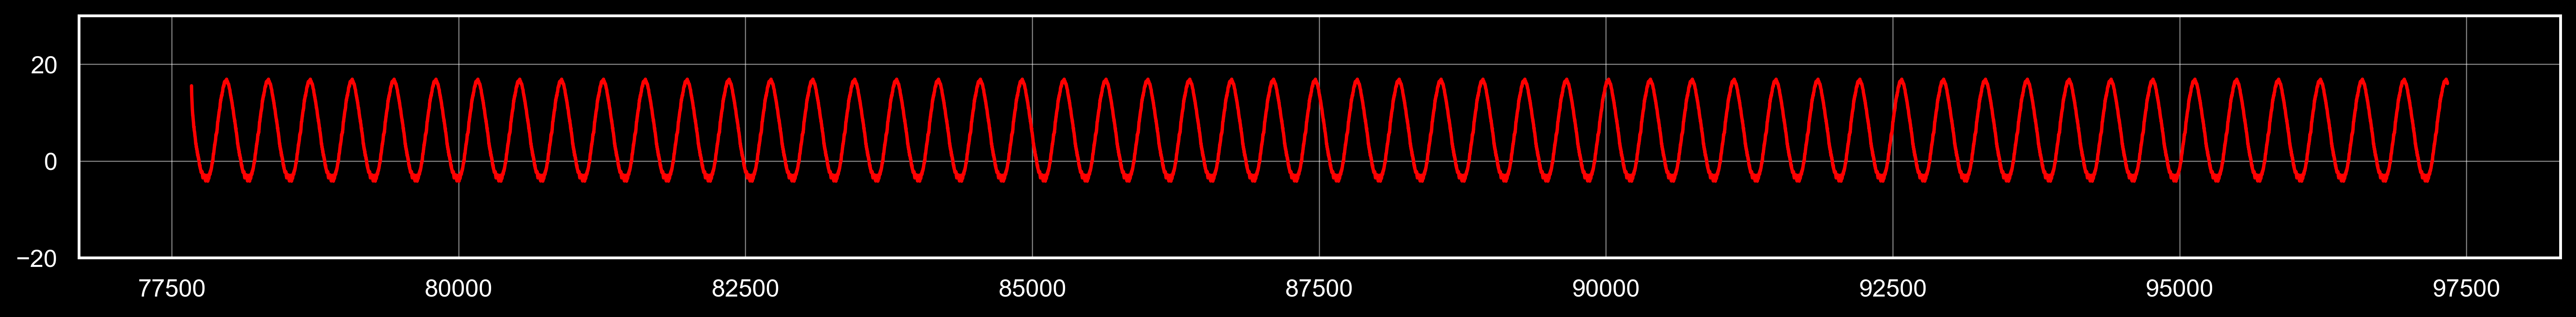

In [68]:
plt.figure(figsize=(20, 2), dpi=400)
plt.axis([None, None, -20, 30])
plt.plot(pred, color='red')

In [21]:
test_data

77672    15.7
77673    17.4
77674    15.9
77675    19.8
77676    18.3
         ... 
97329    20.6
97330    21.9
97331    23.1
97332    24.1
97333    24.1
Name: adjust, Length: 19662, dtype: float64

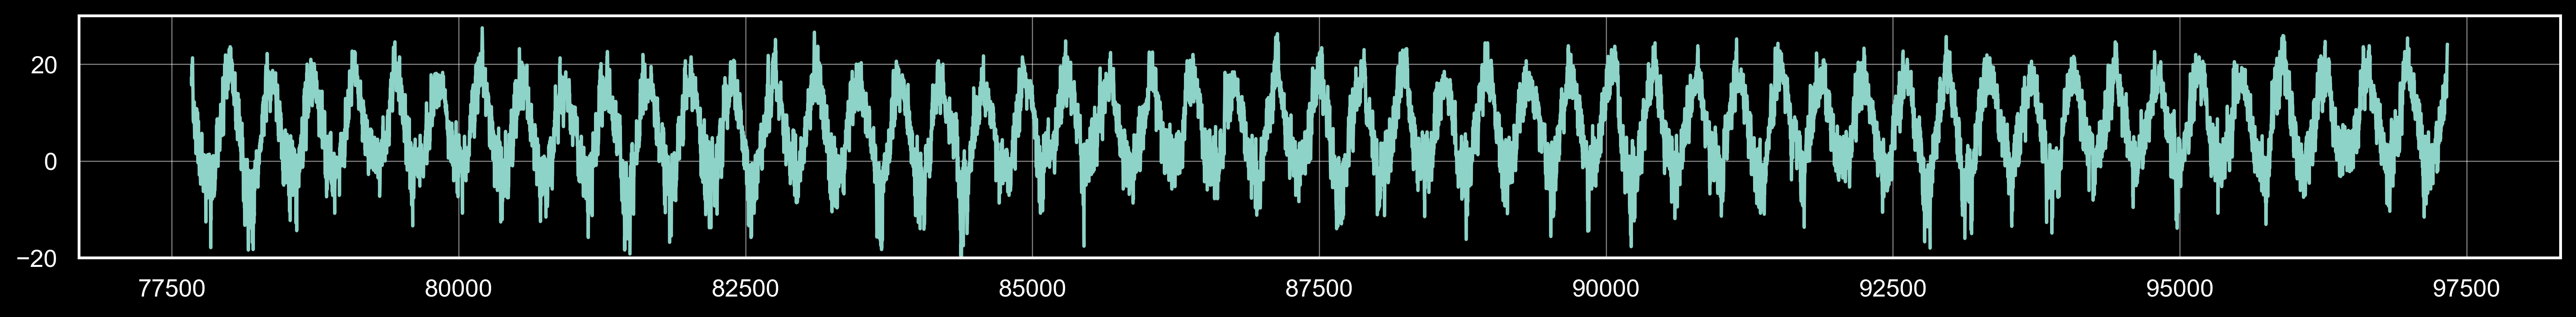

In [71]:
plt.figure(figsize=(20, 2), dpi=400)
plt.axis([None, None, -20, 30])
plt.plot(test_data)